In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.optim.lr_scheduler import StepLR

from model import EfficientNet_B0

from torchvision import transforms
from sklearn.metrics import average_precision_score
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from voc_dataloader import VocDataset, VOC_CLASSES

%load_ext autoreload
%autoreload 2


In [2]:
def train_classifier(train_loader, classifier, criterion, optimizer):
    classifier.train()
    loss_ = 0.0
    losses = []
    for i, (images, labels, _) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = classifier(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss)
    return torch.stack(losses).mean().item()

In [3]:
def test_classifier(test_loader, classifier, criterion, print_ind_classes=True, print_total=True):
    classifier.eval()
    losses = []
    with torch.no_grad():
        y_true = np.zeros((0,21))
        y_score = np.zeros((0,21))
        for i, (images, labels, _) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            logits = classifier(images)
            y_true = np.concatenate((y_true, labels.cpu().numpy()), axis=0)
            y_score = np.concatenate((y_score, logits.cpu().numpy()), axis=0)
            loss = criterion(logits, labels)
            losses.append(loss.item())
        aps = []
        # ignore first class which is background
        for i in range(1, y_true.shape[1]):
            ap = average_precision_score(y_true[:, i], y_score[:, i])
            if print_ind_classes:
                print('-------  Class: {:<12}     AP: {:>8.4f}  -------'.format(VOC_CLASSES[i], ap))
            aps.append(ap)

        mAP = np.mean(aps)
        test_loss = np.mean(losses)
        if print_total:
            print('mAP: {0:.4f}'.format(mAP))
            print('Avg loss: {}'.format(test_loss))

    return mAP, test_loss, aps

In [4]:
def plot_losses(train, val, test_frequency, num_epochs):
    plt.plot(train, label="train")
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0)]
    plt.plot(indices, val, label="val")
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

def plot_mAP(train, val, test_frequency, num_epochs):
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0)]
    plt.plot(indices, train, label="train")
    plt.plot(indices, val, label="val")
    plt.title("mAP Plot")
    plt.ylabel("mAP")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()


## Training the network 

In [5]:
def train(classifier, num_epochs, train_loader, val_loader, criterion, optimizer, test_frequency=5):
    train_losses = []
    train_mAPs = []
    val_losses = []
    val_mAPs = []

    for epoch in range(1,num_epochs+1):
        print("Starting epoch number " + str(epoch))
        train_loss = train_classifier(train_loader, classifier, criterion, optimizer)
        train_losses.append(train_loss)
        print("Loss for Training on Epoch " +str(epoch) + " is "+ str(train_loss))
        if(epoch%test_frequency==0 or epoch==1):
            mAP_train, _, _ = test_classifier(train_loader, classifier, criterion, False, False)
            train_mAPs.append(mAP_train)
            mAP_val, val_loss, _ = test_classifier(val_loader, classifier, criterion)
            print('Evaluating classifier')
            print("Mean Precision Score for Testing on Epoch " +str(epoch) + " is "+ str(mAP_val))
            val_losses.append(val_loss)
            val_mAPs.append(mAP_val)
            
    return classifier, train_losses, val_losses, train_mAPs, val_mAPs

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std= [0.229, 0.224, 0.225])

# Use random crop and flip for training
train_transform = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize
        ])

test_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])

ds_train = VocDataset('VOCdevkit_2007/VOC2007/','train',train_transform)
ds_val = VocDataset('VOCdevkit_2007/VOC2007/','val',test_transform)
ds_test = VocDataset('VOCdevkit_2007/VOC2007test/','test', test_transform)

In [7]:
num_epochs = 60
test_frequency = 10
batch_size = 36
# set a higher number of workers for better performance
num_workers = 4

train_loader = torch.utils.data.DataLoader(dataset=ds_train,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            pin_memory=True,
                                            num_workers=num_workers)

val_loader = torch.utils.data.DataLoader(dataset=ds_val,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            pin_memory=True,
                                            num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(dataset=ds_test,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               pin_memory=True,
                                               num_workers=num_workers)

Efficient Net B0

started 1:39

In [8]:
classifier = EfficientNet_B0().to(device)

criterion = nn.MultiLabelSoftMarginLoss()

optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
# scheduler = StepLR(optimizer, step_size=2, gamma=0.97)

classifier, train_losses, val_losses, train_mAPs, val_mAPs = \
    train(classifier, num_epochs, train_loader, val_loader, criterion, optimizer, test_frequency)



Starting epoch number 1
Loss for Training on Epoch 1 is 0.44749385118484497
-------  Class: aeroplane        AP:   0.0527  -------
-------  Class: bicycle          AP:   0.0557  -------
-------  Class: bird             AP:   0.0545  -------
-------  Class: boat             AP:   0.0410  -------
-------  Class: bottle           AP:   0.0415  -------
-------  Class: bus              AP:   0.0393  -------
-------  Class: car              AP:   0.1431  -------
-------  Class: cat              AP:   0.0703  -------
-------  Class: chair            AP:   0.1131  -------
-------  Class: cow              AP:   0.0306  -------
-------  Class: diningtable      AP:   0.0548  -------
-------  Class: dog              AP:   0.0858  -------
-------  Class: horse            AP:   0.0593  -------
-------  Class: motorbike        AP:   0.0522  -------
-------  Class: person           AP:   0.4137  -------
-------  Class: pottedplant      AP:   0.0478  -------
-------  Class: sheep            AP:   0.018

Loss for Training on Epoch 41 is 0.17482413351535797
Starting epoch number 42
Loss for Training on Epoch 42 is 0.1751929372549057
Starting epoch number 43
Loss for Training on Epoch 43 is 0.17503564059734344
Starting epoch number 44
Loss for Training on Epoch 44 is 0.1739429533481598
Starting epoch number 45
Loss for Training on Epoch 45 is 0.17271742224693298
Starting epoch number 46
Loss for Training on Epoch 46 is 0.17166882753372192
Starting epoch number 47
Loss for Training on Epoch 47 is 0.17016100883483887
Starting epoch number 48
Loss for Training on Epoch 48 is 0.16778624057769775
Starting epoch number 49
Loss for Training on Epoch 49 is 0.16943809390068054
Starting epoch number 50
Loss for Training on Epoch 50 is 0.16738033294677734
-------  Class: aeroplane        AP:   0.6522  -------
-------  Class: bicycle          AP:   0.3194  -------
-------  Class: bird             AP:   0.3251  -------
-------  Class: boat             AP:   0.4173  -------
-------  Class: bottle     

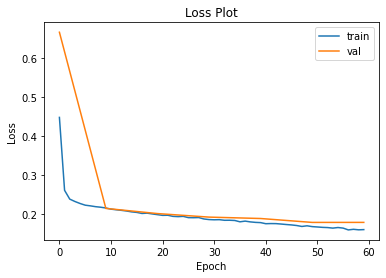

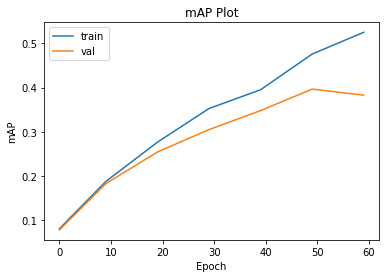

In [9]:
# Compare train and validation metrics
plot_losses(train_losses, val_losses, test_frequency, num_epochs)
plot_mAP(train_mAPs, val_mAPs, test_frequency, num_epochs)